In [1]:
import numpy as np
from matplotlib import pyplot as plt
import cv2

def disp_img(ax, img, title=None, rand_color=False):
    if img.max() == 1 and img.dtype == np.uint8:
        img = img*255
    if rand_color:
        img = img.astype(np.uint8)
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR);
        colors = np.random.randint(0, 255, size=(256, 1, 3)).astype(np.uint8)
        colors[0] = 255
        img_col = cv2.LUT(img, colors)
        ax.imshow(img_col)
    else:
        ax.imshow(img, cmap='gray')
    if title:
        ax.set_title(title)
    ax.axis(False)

---
#### P4: Morphological Operations

---
<div class="alert alert-info">
<p>
University of Applied Sciences Munich<br>
Dept of Electrical Enineering and Information Technology<br>
Institute for Applications of Machine Learning and Intelligent Systems (IAMLIS)<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;(c) Alfred Schöttl 2024<br>
</p>
</div> 

In this notebook, you shall count the number of teeth on a cog utilizing morphological operations. 

__*Helpful tools:*__
You will need to display a lot of images. The helper function `disp_img` shall assist you. Use it by defining a figure and one or several _axes_ (another word for subplots) first:
- `fig, ax = plt.subplots(figsize=(18,12))`          for one axis (the size is in inch)
- `fig, axs = plt.subplots(1, 3, figsize=(18,12))`   for several axes (here, 1 row with 3 images can be displayed)

The argument `figsize` is optional, it defines the size of the whole figure. Then, plot an image by
- `disp_img(ax, img, 'my image')` for one axis
- `disp_img(axs[1], img, 'my_image')` for several axes, the image is displayed on the second axis `axs[1]`

The additional argument `rand_color=True` in `disp_img` can be set to replace gray values by random colors which will turn out to the helpful at the end of the assignment. 

## Assignment
This time, everything is up to you! You are given an RGB image. Your task is to count the number of teeth on the cog. Use the function `disp_img(...)` to display the image as described above. You should give every displayed imaga a unique name.

In [3]:
fn = './imgs/' + 'cogwheel.jpg'
img = cv2.imread(fn, cv2.IMREAD_GRAYSCALE)
if img is None:
    print("Couldn't open image.")
img = img.astype(float)
img = img/np.max(img)
print(img.shape)

(1000, 1000)


## 1. Preprocessing
Obtain a binary image of the big cog (cut off the screws). You may hard-code the coordinates. Do not forget to blur the image a little! The preprocessed image shall be stored in `img_preproc`. _It is useful for the further processing steps if the segments of interest (the cog) is represented by on-pixels (value 1) and the background by off-pixels (value 0)._

_Tips_:
- Use numpy slices like `A[23:167, :500]` to slice the image spatially.
- Use numpy conditions like `A > 100` to get a boolean image. Use `(A>100).astype(np.uint8)` to convert it to a byte image which might be easier to work with later.
- Plot the intermediate results.
- _If you are not sure about your result: an exemplary result of img_preproc is given for reference at the end of this notebook._

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


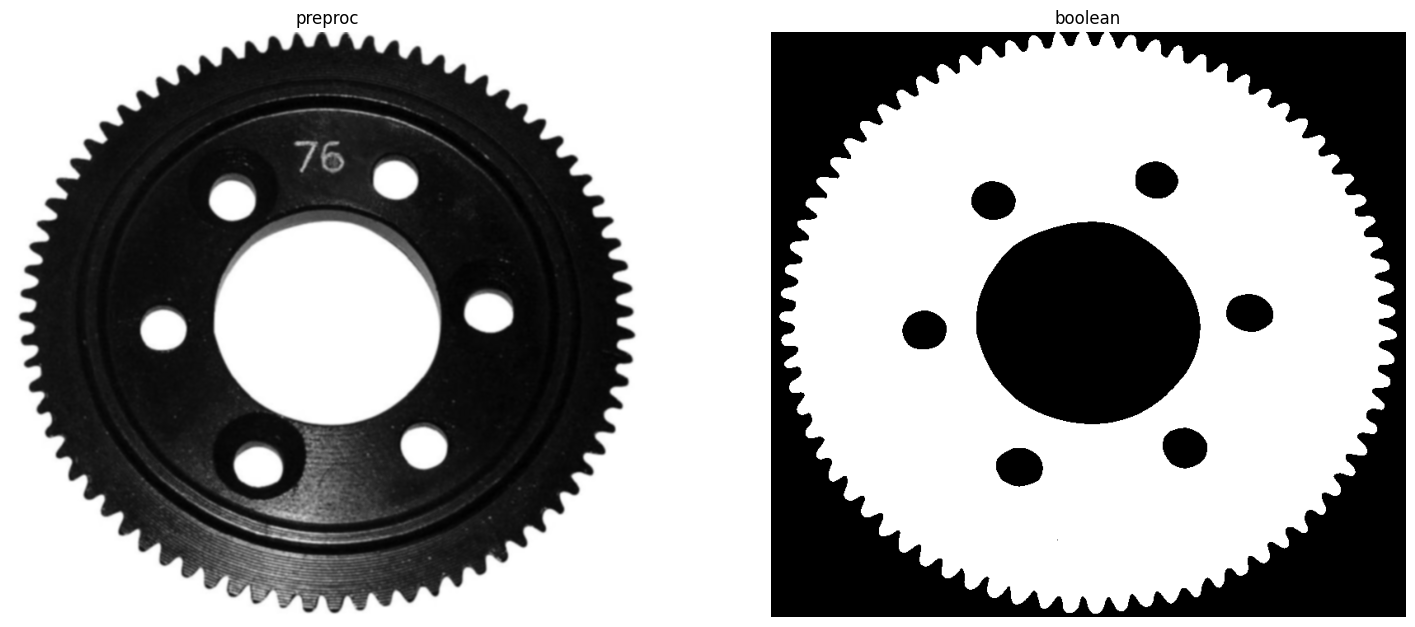

In [50]:
img_preproc = img[150:860, 30:800]
img_preproc_blur = cv2.GaussianBlur(img_preproc, (5,5), 0)
#gaussian smoothing bluring, then thresholding the greyed 'average' to include it in the black part
fig, axs = plt.subplots(1, 2, figsize=(18,12))
disp_img(axs[0], img_preproc_blur, title = 'preproc')
img_bool = (img_preproc_blur<0.85).astype(np.uint8)

print(img_bool)
disp_img(axs[1], img_bool, title = 'boolean')

## 2. Morphological operations on the binary image
Any ideas of how to apply morphological operations to come closer to our goal? Think about it a little, you will need several steps. Save the result of your morphological operations as `img_morph`.

_Tips:_
- It is sufficient to use a combination of the morphological operations `cv2.erode(..., se)`, `cv2.dilate(..., se)` (see the documentation). 
- The operations need a _structuring element_ `se`, which can be obtained by `se = cv2.getStructuringElement(element, (sizeX, sizeY))`. Available elements are `cv2.MORPH_ELLIPSE`, `cv2.MORPH_RECT`, `cv2.MORPH_CROSS`, you can also define arbitrary elements just by a `uint8` numpy array. Try `print(cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (6,6)))` to get a feeling for the elements.
- All morphological operations have an optional argument `iterations=` which is very useful if you want to apply the operation several times.
- Again, you will need to play with parameters. It is therefore very helpful to visualize every intermediate step.
- You will need to subtract two images in a later step. Be cautious with differences of byte-valued (`np.uint8`) images! Numpy implements the ordinary modulo 256 arithmetic (13-14=255) for them! Change the data type before taking the difference or use the OpenCV function `cv2.subtract(img1, img2)` which implements clipping (13-14=0). 
- _If you are not sure about your method: an exemplary result of an intermediate step is given for reference at the end of this notebook._

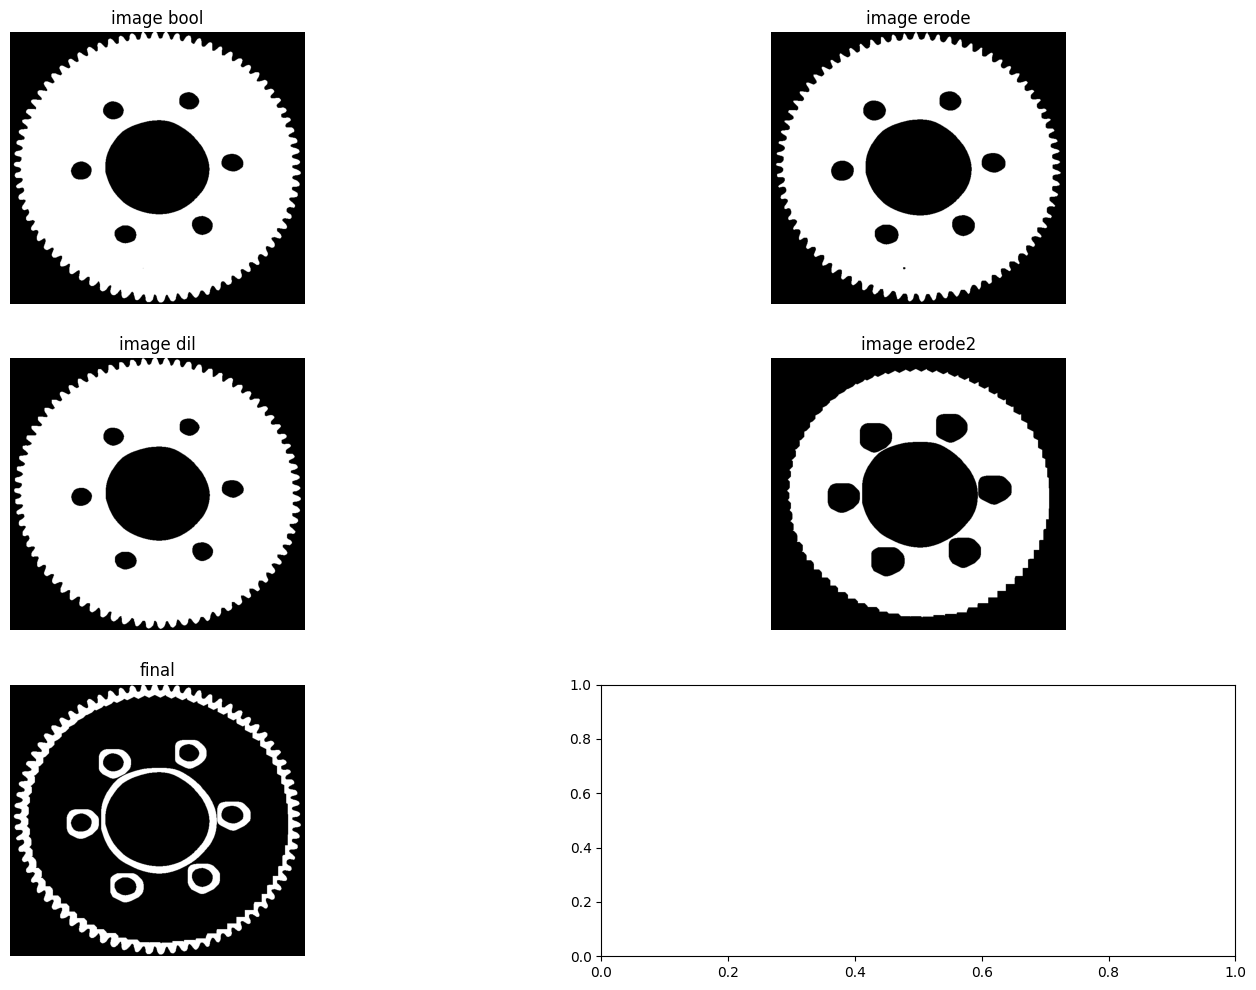

In [69]:
se = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (6,6))
img_erode = cv2.erode(img_bool,se)          #removes white noise, but also shrinks the image
img_dil = cv2.dilate(img_erode, se)         #dilute it again, but noise is gone
img_erode2 = cv2.erode(img_dil,se, iterations = 6)          #erode again without noise
img_final = img_erode2 - img_bool
fig, axs = plt.subplots(3, 2, figsize=(18,12))
disp_img(axs[0,0], img_bool, title= 'image bool')
disp_img(axs[0,1], img_erode, title= 'image erode')
disp_img(axs[1,0], img_dil, title= 'image dil')
disp_img(axs[1,1], img_erode2, title= 'image erode2')
disp_img(axs[2,0], img_final, title= 'final')

## 3. Connected component analysis
Your final result `ìmg_morph` of the last section should now consist of lots of blobs, one for each cog. 

Use the 2-pass algorithm we encountered in class. The OpenCV implementation `cnt, lbl_img, stats, centroids = cv2.connectedComponentsWithStats(...)` returns the processed `lbl_img` as well as the number `cnt` of connected components. The `stats` is a list of tuples with 5 numbers, containing the bounding box coordinates for each component and its area in pixels. The `centroids` is a list of center points of the detected components. Since the image itself is seen as a component (the first one in the lists), you have to subtract 1 from the returned `cnt`.

We print out the number of the detected components and the returned image. The returned image contains the number of the component as gray value for each pixel. This may be difficult to visualize since similar gray values can hardly be distinguished. Try out `disp_img(lbl_img, 'labeled image', rand_color=True)` which gives every gray value a random color.

_Optional:_ 
Another approach is to use `cv2.findCountours` and `cv2.drawContours` to detect and plot the contours of the connected components. Try it out!

In [ ]:
cnt, lbl_img, stats, centroids = 
print(

plt.subplots(figsize=(18,12))             # enlarges the image which may help if you want to analyse single pixels
disp_img(

---

### Hints if you are unsure:
Here is an exemplary result of the first section (`img_preproc`):
![P4_target_1.png](P4_target_1.png)


This is an intermediate result of the second section. To obtain the result `img_morph` of the second section, you have to subtract another image and postprocess the difference:
![P4_target_2.png](P4_target_2.png)
